<a href="https://colab.research.google.com/github/lambrosfloudas/Thesis_/blob/main/Sentiment_Analysis_Dialogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.1 MB/s 
     |████████████████████████████████| 115 kB 59.8 MB/s 
     |████████████████████████████████| 163 kB 56.8 MB/s 
     |████████████████████████████████| 212 kB 49.0 MB/s 
     |████████████████████████████████| 127 kB 54.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.1 MB/s 
     |████████████████████████████████| 7.6 MB 43.5 MB/s 


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
sia = SentimentIntensityAnalyzer()
plt.style.use('ggplot')
from scipy.special import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
from textblob import TextBlob
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from datasets import load_dataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [4]:
dataset = load_dataset('bdotloh/empathetic-dialogues-contexts')

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/bdotloh___csv/bdotloh--empathetic-dialogues-contexts-f09f6b0762faa070/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame(dataset['validation'])

In [6]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
df

,situation,emotion
0,"Today,as i was leaving for work in the morning...",terrified
1,I was walking through my hallway a few week ag...,surprised
2,I'm overly excited today because will be flyin...,excited
3,"I was holding my son over my head, playing wit...",disgusted
4,I felt caring when i helped an elderly lady ca...,caring
...,...,...
2751,I work at a library cataloging materials and o...,confident
2752,When I was a teenager I stole some comic books...,guilty
2753,"When I went into labor with my son, it was qui...",prepared
2754,One time I studied all night for my final exam!,prepared


In [8]:
df['emotion'].unique()

array(['terrified', 'surprised', 'excited', 'disgusted', 'caring',
       'sentimental', 'sad', 'embarrassed', 'afraid', 'impressed',
       'grateful', 'joyful', 'proud', 'hopeful', 'faithful', 'lonely',
       'confident', 'annoyed', 'anticipating', 'furious', 'jealous',
       'nostalgic', 'apprehensive', 'guilty', 'ashamed', 'prepared',
       'anxious', 'content', 'angry', 'devastated', 'trusting',
       'disappointed'], dtype=object)

In [9]:
df['polarity'] = 0

In [10]:
for i in range(len(df)):
  if df['emotion'][i] in ['terrified', 'disgusted', 'sad', 'embarrassed', 'afraid', 'lonely', 'annoyed', 'furious', 'jealous', 'apprehensive', 'guilty', 'ashamed', 'anxious', 'angry', 'devastated', 'disappointed']:
    df.polarity[i] = 0
  else:
    df.polarity[i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


**VADER Sentiment Analysis**

In [11]:
df['VaderComp'] = 0.0
df['PolarityVader'] = 0
df['ScoreVader'] = 0

In [12]:
for i in range(len(df)):
  try:
    text = df.situation[i] # Get each row as text
    # Store Positive, Negative, Neutral scores and compound score for each row
    df['VaderComp'][i] = sia.polarity_scores(text)['compound']
    # Classify each comment as negative, positive and neutral according to scores. 0.33 was decided as a benchmark so that it gives equal spaces to all 3 polarities. 
    if sia.polarity_scores(text)['compound'] < 0:
      df['PolarityVader'][i] = 'Negative'
      df['ScoreVader'][i] = 0
    elif sia.polarity_scores(text)['compound'] > 0:
      df['PolarityVader'][i] = 'Positive'
      df['ScoreVader'][i] = 1
    else:
      df['PolarityVader'][i] = 'Neutral'
      df['ScoreVader'][i] = 2
  except:
    print(f'Broke for id {i}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_l

In [14]:
df['PolarityBlob'] = 0.0
df['SubjectivityBlob'] = 0.0
df['SentimentBlob'] = 0
df['SentimentBlobScore'] = 0

In [15]:
for i in range(len(df)):
  try:
    text = df.situation[i]
    blob = TextBlob(text)
    df['PolarityBlob'][i] = blob.sentiment[0]
    df['SubjectivityBlob'][i] = blob.sentiment[1]
  except:
    print(f'Broke for id {i}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
# Classify each row's text as neutral, positive or negative according to results taken from TextBlob
for i in range(len(df)):
  if df.PolarityBlob[i] == 0.0:
    df.SentimentBlob[i] = 'Neutral'
    df.SentimentBlobScore[i] = 2
  elif df.PolarityBlob[i] > 0:
    df.SentimentBlob[i] = 'Positive'
    df.SentimentBlobScore[i] = 1
  elif df.PolarityBlob[i] < 0:
    df.SentimentBlob[i] = 'Negative'
    df.SentimentBlobScore[i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/i

In [17]:
df['PolarityPipeline'] = 0
df['ScorePipeline'] = 0.0
df['SentimentPipelineScore'] = 0.0

In [18]:
# Apply the pipeline model for each row.
sent_pipeline = pipeline('sentiment-analysis')
for i in range(len(df)):
  try:
    text = df.situation[i]
    df['PolarityPipeline'][i] = sent_pipeline(text)[0]['label']
    df['ScorePipeline'][i] = sent_pipeline(text)[0]['score']
  except:
    print(f'Broke for id {i + 1}')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [19]:
# Classify per pipeline's results.
for i in range(len(df)):
  if df.PolarityPipeline[i] == 0:
    df.SentimentPipelineScore[i] = 2
    df.PolarityPipeline[i] = 'Neutral'
  elif df.PolarityPipeline[i] == 'POSITIVE':
    df.SentimentPipelineScore[i] = 1
    df.PolarityPipeline[i] = 'Positive'
  elif df.PolarityPipeline[i] == 'NEGATIVE':
    df.SentimentPipelineScore[i] = 0
    df.PolarityPipeline[i] = 'Negative'
  else:
    print(i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [20]:
df['RobertaPos'] = 0.0
df['RobertaNeg'] = 0.0
df['RobertaNeu'] = 0.0
df['PolarityRoberta'] = 0
df['ScoreRoberta'] = 0

In [21]:
tokenizer = AutoTokenizer.from_pretrained(f"cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained(f"cardiffnlp/twitter-roberta-base-sentiment")
for i in range(len(df)):
  try:
    text = df.situation[i]
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text) # Tensored output
    scores = output[0][0].detach().numpy() # Transform the output from Tensored to numpy array
    scores = softmax(scores)
    df['RobertaPos'][i] = scores[2]
    df['RobertaNeg'][i] = scores[0]
    df['RobertaNeu'][i] = scores[1]
  except:
    print(f'Broke for id {i}')

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
# Classify each row according to which polarity has higher percentage given by Roberta.
for i in range(len(df)):
  if df.RobertaNeu[i] >= df.RobertaPos[i] and df.RobertaNeu[i] >= df.RobertaNeg[i]:
    df.PolarityRoberta[i] = 'Neutral'
    df.ScoreRoberta[i] = 0
  elif df.RobertaPos[i] >= df.RobertaNeg[i] and df.RobertaPos[i] >= df.RobertaNeu[i]:
    df.PolarityRoberta[i] = 'Positive'
    df.ScoreRoberta[i] = 1
  elif df.RobertaNeg[i] >= df.RobertaPos[i] and df.RobertaNeg[i] >= df.RobertaNeu[i]:
    df.PolarityRoberta[i] = 'Negative'
    df.ScoreRoberta[i] = -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [23]:
for i in range(len(df)):
  if df.ScoreRoberta[i] == 0:
    df.ScoreRoberta[i] = 2
  elif df.ScoreRoberta[i] == -1:
    df.ScoreRoberta[i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
df.ScoreRoberta.unique()

array([0, 1, 2])

In [25]:
df = df[df.ScoreRoberta != 2]

In [26]:
df.ScoreRoberta.unique()

array([0, 1])

In [27]:
df = df[df.SentimentPipelineScore != 2]
df = df[df.SentimentBlobScore != 2]
df = df[df.ScoreVader !=2]

In [30]:
df.ScoreVader.unique()

array([0, 1])

In [33]:
 df.SentimentPipelineScore = df.SentimentPipelineScore.astype('int')

In [34]:
df.SentimentPipelineScore.unique()

array([0, 1])

In [38]:
RobertaAcc = accuracy_score(df.polarity, df.ScoreRoberta)
VADERAcc = accuracy_score(df.polarity, df.ScoreVader)
TextBlobAcc = accuracy_score(df.polarity, df.SentimentBlobScore)
PipelineAcc = accuracy_score(df.polarity, df.SentimentPipelineScore)

In [39]:
Robertaf1 = f1_score(df.polarity, df.ScoreRoberta)
VADERf1 = f1_score(df.polarity, df.ScoreVader)
TextBlobf1 = f1_score(df.polarity, df.SentimentBlobScore)
Pipelinef1 = f1_score(df.polarity, df.SentimentPipelineScore)

In [40]:
models_list = ['RoBERTa', 'VADER', 'TextBlob', 'Pipeline']
acclist = [RobertaAcc, VADERAcc, TextBlobAcc, PipelineAcc]
f1list = [Robertaf1, VADERf1, TextBlobf1, Pipelinef1]

In [41]:
dfa = pd.DataFrame({'Accuracy': acclist,'F1 Score': f1list,'Models': models_list})

In [42]:
dfa

,Accuracy,F1 Score,Models
0,0.901561,0.903269,RoBERTa
1,0.827563,0.839849,VADER
2,0.739986,0.773239,TextBlob
3,0.866938,0.867925,Pipeline


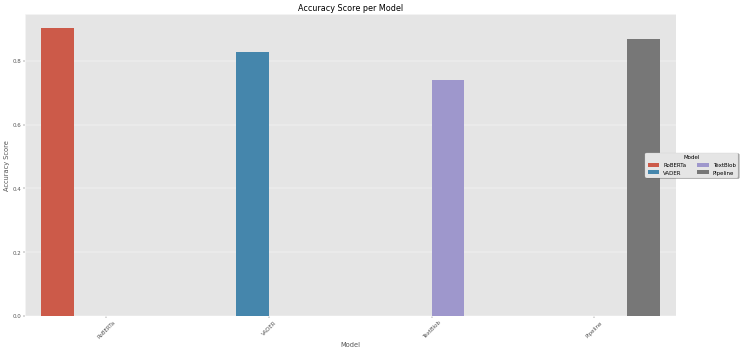

In [43]:
figure = plt.figure(figsize=(21,10), dpi=40)
accplot = sns.barplot(data=dfa, x='Models', y='Accuracy', hue='Models')
plt.legend(title= 'Model', loc='right', bbox_to_anchor=(1.10, 0.5),
               ncol = 2, fancybox=True, shadow=True) #https://matplotlib.org/2.0.2/users/legend_guide.html
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45)
plt.title('Accuracy Score per Model')
plt.show(accplot)

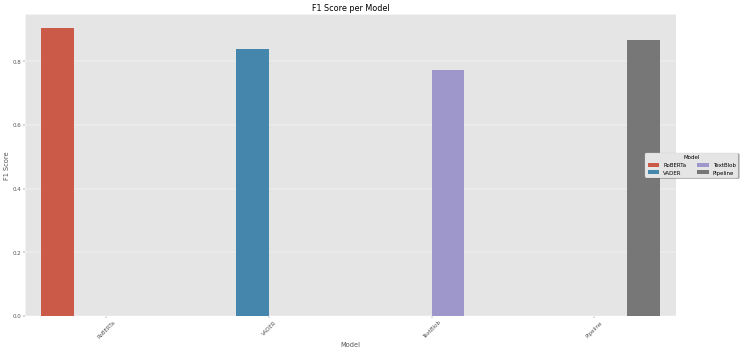

In [44]:
figure = plt.figure(figsize=(21,10), dpi=40)
f1plot = sns.barplot(data=dfa, x='Models', y='F1 Score', hue='Models')
plt.legend(title= 'Model', loc='right', bbox_to_anchor=(1.10, 0.5),
               ncol = 2, fancybox=True, shadow=True) #https://matplotlib.org/2.0.2/users/legend_guide.html
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.title('F1 Score per Model')
plt.show(f1plot)